In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import scipy
import time
import torch

from scipy.stats import binom, binom_test, wilcoxon
from tensorflow import keras

import sbibm

from sbibm.utils.io import get_tensor_from_csv, get_ndarray_from_csv
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st
from utils import compile_df, huber_loss, mean_squared_error

In [2]:
# Plotting settings
plt.style.use('plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

seed 223174


In [3]:
with open("../data/results/posterior-samples-ANA-LAN-MNLE-MNLE*-all-trials-posthoc-metrics-N99.p", "rb") as fh:
    allsamples_dict = pickle.load(fh)

## Parameter recovery all trials

In [4]:
true_params, true_samples, lan_samples, nle_samples, nlee_samples, ranks, meanerr, meanerrabs, varerr, varerrabs, dispersion = allsamples_dict.values()

In [26]:
lan_samples_5 = np.zeros((4, 99, 1000, 4))
lan_samples_8 = np.zeros_like(lan_samples_5)
# mask out observation 76
mask = np.arange(100)!=75
for idx, nt in enumerate([1, 10, 100, 1000]):
    with open(f"../data/results/lan_10_5_ours_posterior_samples_100x{nt}iid_new.p", "rb") as fh:
        lan_samples_5[idx,] = torch.stack(pickle.load(fh)).numpy()[mask,]
    
    with open(f"../data/results/lan_10_8_ours_posterior_samples_100x{nt}iid_new.p", "rb") as fh:
        lan_samples_8[idx,] = torch.stack(pickle.load(fh)).numpy()[mask,]

In [10]:
# NOTE: in the results here observation with idx 75 has been remove! Make sure to adapt new results! 
task = sbibm.get_task("ddm")
ttt = torch.stack([task.get_true_parameters(ii+1) for ii in range(100)]).squeeze()
ttt = ttt[np.arange(100)!= 75]
upto = 99

(true_params[0][:upto] == ttt[:upto].numpy()).all()

True

/home/janfb/anaconda3/envs/mnle/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


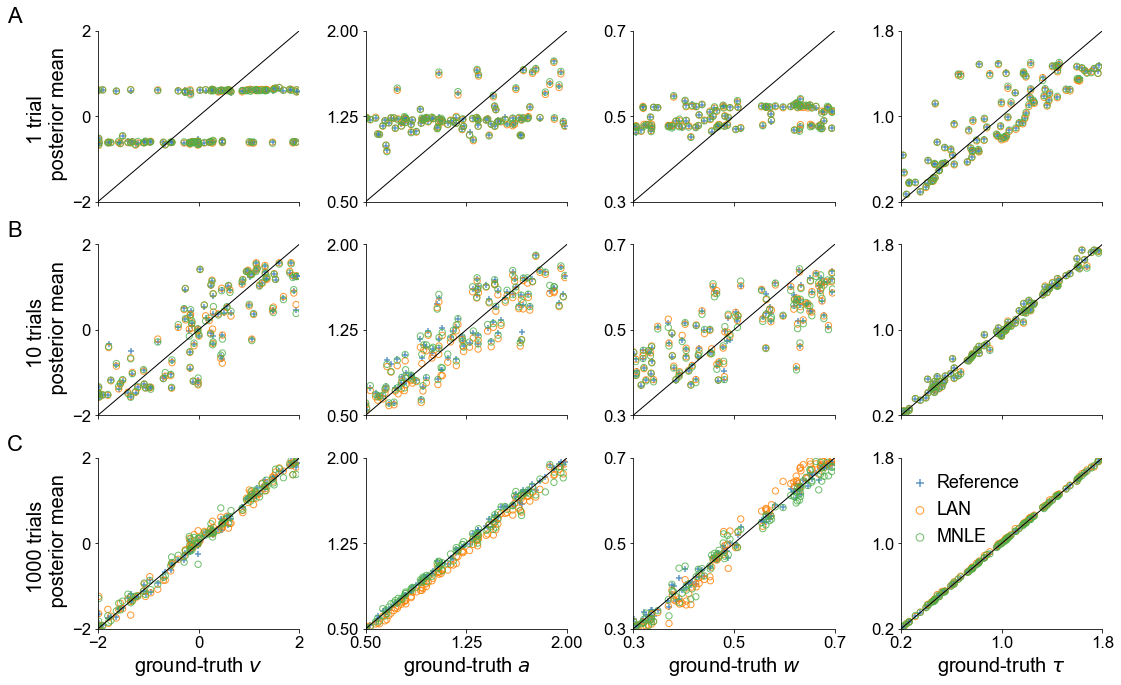

In [11]:
trials_to_show = [1, 10, 1000]
fig, ax = plt.subplots(len(trials_to_show), 4, figsize=(18, 11), 
                      gridspec_kw=dict(wspace=0.33, hspace=0.25), sharex="col")
mpl.rcParams["legend.fontsize"] = 18
s = 40
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
num_trials_list = np.array([1, 10, 100, 1000])

for jj, num_trials in enumerate(trials_to_show):
    trial_idx = np.where(num_trials_list==num_trials)[0]
    for ii in range(4):
#         truth = true_samples.mean(2)[jj, :, ii]
        truth = true_params[trial_idx, :, ii]
        plt.sca(ax[jj, ii])
        plt.scatter(truth, true_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[0], 
                    label=fr"Reference",            
                    alpha=alpha,
#                     facecolors='none'
                    marker="+",
                   )
        plt.scatter(truth, lan_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[1], 
                    label=fr"LAN",            
                    alpha=alpha,
                    facecolors='none'
                   )
        plt.scatter(truth, nle_samples.mean(2)[trial_idx, :, ii], s=s, color=colors[2], 
                    label=fr"MNLE",
                    alpha=alpha,     
                    facecolors='none'
                   )
        
        plt.plot(np.linspace(limits[ii][0], limits[ii][1], 100), 
                 np.linspace(limits[ii][0], limits[ii][1], 100), color="k", lw=1)
        plt.ylim(limits[ii])
        plt.yticks(np.linspace(limits[ii][0], limits[ii][1], 3))

        plt.xlim(limits[ii])
        plt.xticks(np.linspace(limits[ii][0], limits[ii][1], 3))
        if jj==2:
            plt.xlabel("ground-truth " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][ii])
        
        if ii==0:
            plt.ylabel(f"{num_trials} trial{'s' if jj>0 else ''} \n posterior mean")
            
        if ii==3 and jj==2:
            plt.legend(loc=2, markerscale=1.2, handlelength=0.3, frameon=False);

weight = "regular"
fontsize = 22
y1 = 0.89
x1 = 0.055
dx = 0.0
dy = 0.27
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
# fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)            
            
plt.tight_layout();
# fig.savefig("figures/FigureA1-MNLE-LAN-parameter-recovery-over-trials.png", dpi=300, bbox_inches="tight");

## Metric over trials

## Calculate posterior metrics from samples

In [77]:
N = 99
num_num_trials = len(num_trials_list)
num_methods = 5  # 3 LAN, 2 MNLE
meanerr = np.zeros((num_num_trials, N, num_methods))  
varerr = np.zeros_like(meanerr)
dispersion = np.zeros_like(meanerr)
estimation_error = np.zeros_like(meanerr)
estimation_error_reference = ((true_params - true_samples.mean(2))**2).mean(-1)
recalculate_c2st = False

# NOTE: abs differences for mean and var, normalized by true std or var. take mean over param dims (axis -1)
for i, s in enumerate([lan_samples_5, lan_samples_8, lan_samples, nle_samples, nlee_samples]):
    meanerr[:, :, i] = np.mean(abs(true_samples.mean(2) - s.mean(2)) , -1)  
    varerr[:, :, i] = np.mean(abs(true_samples.var(2) - s.var(2)) / true_samples.var(2), -1)
    estimation_error[:, :, i] = np.mean((true_params - s.mean(2))**2, -1)

# Calculate c2st for lower LAN budgets
if recalculate_c2st:
    from joblib import Parallel, delayed
    num_workers = 20
    c2st_scores = np.zeros((num_num_trials, N, num_methods))

    for jj in range(num_num_trials):
        c2st_scores[jj, :, 0] = Parallel(num_workers)(delayed(c2st)(
        torch.tensor(lan_samples_5[jj, ii,]), torch.tensor(true_samples[jj, ii,])
        ) for ii in range(N))
        c2st_scores[jj, :, 1] = Parallel(num_workers)(delayed(c2st)(
            torch.tensor(lan_samples_8[jj, ii,]), torch.tensor(true_samples[jj, ii,])
        ) for ii in range(N))
        c2st_scores[jj, :, 2] = Parallel(num_workers)(delayed(c2st)(
            torch.tensor(lan_samples[jj, ii,]), torch.tensor(true_samples[jj, ii,])
            ) for ii in range(N))
        c2st_scores[jj, :, 3] = Parallel(num_workers)(delayed(c2st)(
            torch.tensor(nle_samples[jj, ii,]), torch.tensor(true_samples[jj, ii,])
            ) for ii in range(N))
        c2st_scores[jj, :, 4] = Parallel(num_workers)(delayed(c2st)(
            torch.tensor(nlee_samples[jj, ii,]), torch.tensor(true_samples[jj, ii,])
            ) for ii in range(N))

    with open("../data/results/c2st_scores_all_num_trials_N99.p", "wb") as fh:
        pickle.dump(c2st_scores, fh)
else: 
    with open("../data/results/c2st_scores_all_num_trials_N99.p", "rb") as fh:
        c2st_scores = pickle.load(fh)

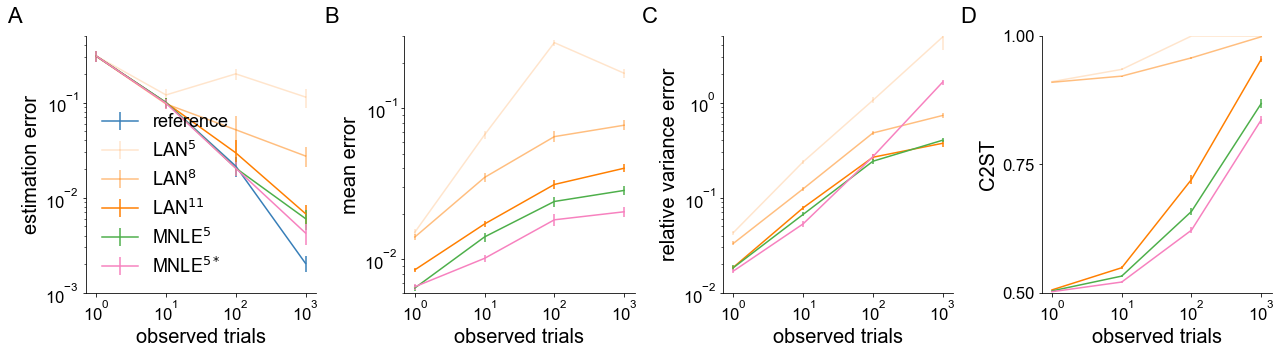

In [94]:
ylabels = ["estimation error", "mean error", "relative variance error", "C2ST"]
bar_posistions = np.arange(0, .4, .12)
bar_width = .1
labels = [
    r"LAN$^5$", 
    r"LAN$^8$", 
    r"LAN$^{11}$", 
    r"MNLE$^5$",
    r"MNLE$^{5*}$",
]
plot_colors = colors[1:2]*3 + colors[2:4]
alphas = [.2, .5, 1., 1., 1.]

fig, ax = plt.subplots(1, 4, figsize=(18, 5), sharex=True)
yscale = 'log'
xlabel= "observed trials"
for ii in range(5): # methods
    plt.sca(ax[0])
    if ii==0:
        plt.errorbar(num_trials_list, estimation_error_reference.mean(1), estimation_error_reference.std(1) / np.sqrt(N), 
            label="reference", color=colors[0])
    plt.errorbar(num_trials_list, estimation_error[:, :, ii].mean(1), estimation_error[:, :, ii].std(1) / np.sqrt(N), 
        label=labels[ii], color=plot_colors[ii], alpha=alphas[ii])
    if ii==4:
        plt.legend()

    plt.sca(ax[1])
    plt.errorbar(num_trials_list, meanerr[:, :, ii].mean(1), meanerr[:, :, ii].std(1) / np.sqrt(N), 
        label=labels[ii], color=plot_colors[ii], alpha=alphas[ii])
    
    plt.sca(ax[2])
    plt.errorbar(num_trials_list, varerr[:, :, ii].mean(1), varerr[:, :, ii].std(1) / np.sqrt(N), 
        label=labels[ii], color=plot_colors[ii], alpha=alphas[ii])
    
    plt.sca(ax[3])
    plt.errorbar(num_trials_list, c2st_scores[:, :, ii].mean(1), c2st_scores[:, :, ii].std(1) / np.sqrt(N), 
        label=labels[ii], color=plot_colors[ii], alpha=alphas[ii])
    plt.yticks(np.linspace(.5, 1., 3))
    plt.ylim(0.5, 1.)

plt.xscale("log")
plt.xticks(num_trials_list);
ylims = [[0.001, .5], [0.006, .3], [0.01, 5.], [0.5, 1.]]

for ii in range(4):
    plt.sca(ax[ii])
    if ii < 3:
        plt.yscale(yscale)
        plt.ylim(ylims[ii])
    plt.xlabel(xlabel)
    plt.ylabel(ylabels[ii])
    
plt.tight_layout()

weight = "regular"
fontsize = 22
y1 = 0.96
x1 = 0.005
dx = 0.245
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+2*dx, y1, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+3*dx, y1, "D", fontsize=fontsize, fontweight=weight)
fig.savefig("figures/FigureA2-MNLE-LAN-posterior-metrics-over-trials.png", dpi=300, bbox_inches="tight");

/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,
/home/janfb/anaconda3/envs/ddm/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:396: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


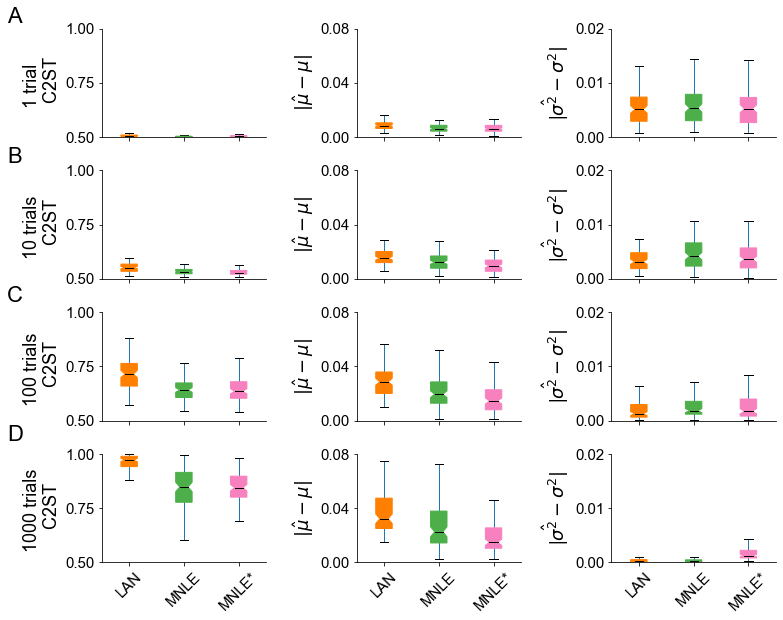

In [15]:
ylabels = ["estimation error", "mean error", "variance error", "C2ST"]

fig, ax2 = plt.subplots(4, 4, figsize=(11, 9), sharey="col", sharex=True)

bar_posistions = np.arange(0, .5, .12)
bar_width = .1

for idx, num_trials in enumerate(num_trials_list):    
    ticks = [[0.5, 1.0], [0, .08], [0., .02]]

    for ii in range(4):
        plt.sca(ax2[idx, ii])
        plot_bar(pos, bar_width, meanerr[:, ii], label=labels[ii], color=plot_colors[ii+1], alpha=alphas[ii+1])
        if ii==0:
            plt.ylabel(f"{[1, 10, 100, 1000][idx]} trial{'s' if idx>0 else ''} \n {ylabels[ii]}")
        else:
            plt.ylabel(ylabels[ii])
        
        if ii < 2:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3))
            plt.ylim(*ticks[ii])
        else:
            plt.yticks(np.linspace(ticks[ii][0], ticks[ii][1], 3 if idx < 3 else 3))
            plt.ylim(*ticks[ii])

        if idx == 3:
            plt.xticks([1, 2, 3], ["LAN", "MNLE", "MNLE*"], rotation=45)
    plt.suptitle("")
    ii = 0
    for row_key, (axi,row) in bdict.iteritems():
        ii += 1
        for i,box in enumerate(row['boxes']):
            box.set_color(colors[i+1])

weight = "regular"
fontsize = 22
y1 = 0.94
x1 = 0.005
dx = 0.0
dy = 0.215
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)
# fig.text(x1, y1-0.53, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/FigureA2-MNLE-LAN-posterior-metrics-over-trials.png", dpi=300, bbox_inches="tight");

## SBC over trials

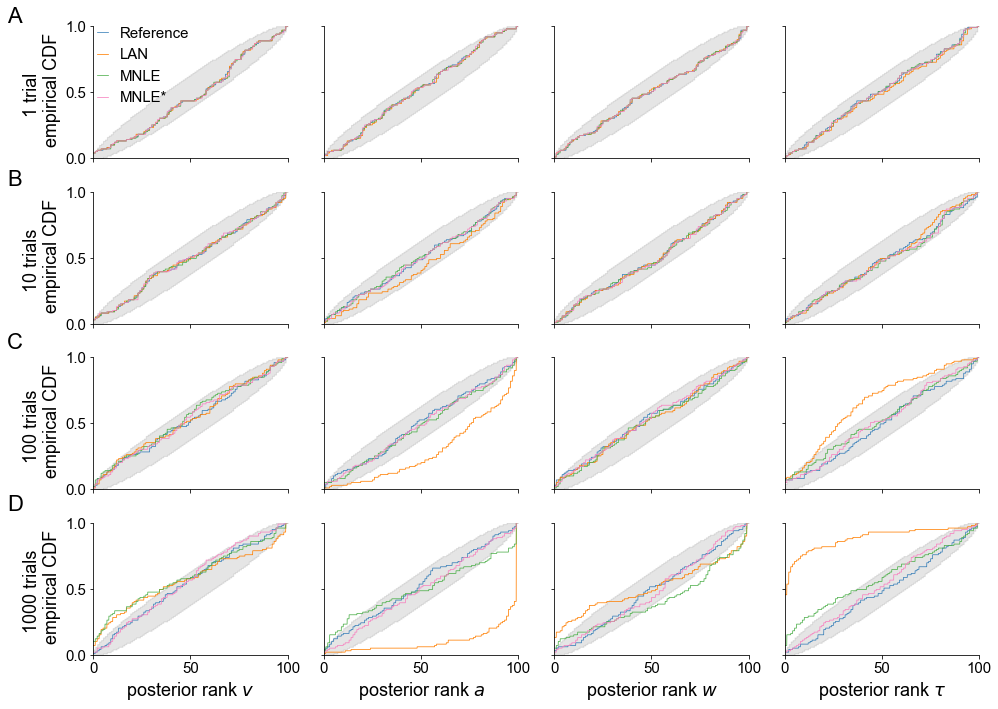

In [16]:
fig, ax1 = plt.subplots(4, 4, figsize=(14, 10), sharey=True, sharex=True)
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["font.size"] = 18
num_methods = 4
notch = True
showfliers = False
labels = ["Reference", "LAN", "MNLE", "MNLE*"]
s = 20
alpha=0.8
limits = [[-2, 2], [0.5, 2.], [0.3, 0.7], [0.2, 1.8]]
repeats = 50
nbins = 100
N = 99

from scipy.stats import binom

for kk in range(len(num_trials_list)):
    for ii in range(num_methods):
        for jj in range(4):
            plt.sca(ax1[kk, jj])
            hist, *_ = np.histogram(ranks[kk, :, jj, ii], bins=nbins, density=False)
            histcs = hist.cumsum()
            plt.plot(np.linspace(0, nbins, repeats*nbins), 
                     np.repeat(histcs / histcs.max(), repeats), 
                     label=labels[ii], 
                     color=colors[:num_methods][ii], 
                     alpha=1., 
                     lw=.75)
            if jj==0:
                plt.yticks(np.linspace(0, 1, 3))
                plt.ylabel(f"{[1, 10, 100, 1000][kk]} trial{'s' if kk>0 else ''} \n empirical CDF")
                if kk == 0:
                    plt.legend(loc=2, markerscale=1., handlelength=0.75, bbox_to_anchor=(-.05, 1.1))
            else:
                plt.yticks(np.linspace(0, 1, 3), np.linspace(0, 1, 3))
            plt.ylim(0, 1)
            plt.xlim(0, nbins)
            plt.xticks(np.linspace(0, nbins, 3))
            if kk == 3:
                plt.xlabel("posterior rank " + [r"$v$", r"$a$", r"$w$", r"$\tau$"][jj])
            if ii==0:
                # Construct uniform histogram.
                hb = binom(N, p=1 / nbins).ppf(0.5) * np.ones(nbins)
                hbb = hb.cumsum() / hb.sum()

                lower = [binom(N, p=p).ppf(0.005) for p in hbb]
                upper = [binom(N, p=p).ppf(0.995) for p in hbb]

                # Plot grey area with expected ECDF.
                plt.fill_between(x=np.linspace(0, nbins, repeats*nbins), 
                             y1=np.repeat(lower / np.max(lower), repeats), 
                             y2=np.repeat(upper / np.max(lower), repeats), 
                             color="grey", 
                             alpha=0.2)
weight = "regular"
fontsize = 22
y1 = 0.97
x1 = 0.004
dx = 0.0
dy = 0.226
fig.text(x1, y1, "A", fontsize=fontsize, fontweight=weight)
fig.text(x1, y1-2*dy, "C", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-dy, "B", fontsize=fontsize, fontweight=weight)
fig.text(x1+dx, y1-3*dy, "D", fontsize=fontsize, fontweight=weight)
# fig.text(x1, y1-0.53, "C", fontsize=fontsize, fontweight=weight)

plt.tight_layout();
fig.savefig("figures/FigureA3-MNLE-LAN-sbc-over-trials.png", dpi=300, bbox_inches="tight");